In order to successfully complete this assignment you must follow all instructions in this notebook and upload your files with your answers on or before **11:59pm on Friday February 15th**.

 <font color=red>**WARNING:**</font> This homework will require you to submit long running jobs on the HPCC.  You must account for variable queue times when submitting jobs.   Two weeks is plenty of time for the jobs to finish as long as you **start early**.   This homework is not something you will get done in one block of time.  I highly suggest getting though parts 1-3 as early as possible so you will have time to submit jobs for the timing study. There is no excuse that jobs did not finish in time. Part of the lesson is budgeting your time to account for queue times on a shared resource.

# Homework 3: Genome Assembly

![wiki shotgun sequencing](https://upload.wikimedia.org/wikipedia/commons/d/dd/Seqassemble.png)

<p style="text-align: right;">Image from: https://en.wikipedia.org/wiki/Shotgun_sequencing</p>

As an Parallel Programming and Linux/HPC expert it will be common for other researchers to email you and ask for some help.  In this assignment we are going to help a research group move their workflow over onto SLURM.  Here is the email from the lead PI (Principal Investigator) in the research group:

> Hello Research Facilitator,
>
> I was hoping you could help us.  The attached code aligns real human genome sequencing reads (public domain dataset) to the human genome.  See script ```getGiabData.sh``` to download the actual data from the Genome in a Bottle project website.  The reference genome is available from  Ensembl (ftp://ftp.ensembl.org/pub/release-94/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.toplevel.fa.gz).  Use ```runBwaIndex_slurm_giab.sb``` to index the reference genome (bookkeeping, runs reasonably fast).  Then use ```runBwaAln_slurm_giab_noRg.sb``` to debug how to get Burrows-Wheeler Aligner (BWA) to align the reads to the reference.  This script actually doesn't work because we were experiencing the SLURM upgrades right as we were handling this topic so while the software can use multiple threads, we didn't figure out how to get SLURM to do it (see [BWA manual](http://bio-bwa.sourceforge.net/bwa.shtml)).  Our group was able to turn the number of threads down to 1 and crank up the memory to get it work.  However the time it takes to run the alignment job varies considerably based on threads/memory.  I've included some slides from a group discussion that talks about this code to give some background.  Could you help us write a new SLURM submission script that takes advantage of parallel programming and optimizes the throughput on the HPC?
> 
> Also, could you get back to me no later than Friday February 15th so we can start some jobs over the weekend?
> 
> Thank you,
>
>    Awesome PI

Turns out that the example code takes a long time to run.  Pretend that you sent the following email to the PI.


> Dear Awesome PI,
>  
I am running the Indexing step (runBwaIndex_slurm_giab.sb) and so far it is taking close to 33G of total memory and 3 hours (1830 iterations done and counting) of walltime. According to your email “bookkeeping, runs reasonably fast” and you gave the index submission script only 10 minutes to run and only 2GB of ram.  Am I doing something wrong?
>  
>Thanks,
>
>  Research Facilitator

The PI then responded with the following email:

> Hello Research Facilitator,
> 
> For the human genome, it does tend to take a few hours.  If you need something shorter for testing, we can use a smaller, less complex genome. I'm sending you some worm RNA-Seq data.  C. elegans is much smaller and is a less complex genome, so it should go much faster. You can download the worm reference genome from Ensembl from here:
>
> ftp://ftp.ensembl.org/pub/release-95/fasta/caenorhabditis_elegans/dna/Caenorhabditis_elegans.WBcel235.dna.toplevel.fa.gz
> 
> I also included exaple data files which I put on the HPCC in the following directories:
>
> /mnt/scratch/colbrydi/BWA_Example_Data/DataSet01_Celegans_Paired200Id200Pexp100Cov10E1N0GenomicControl_1.fq.gz
> /mnt/scratch/colbrydi/BWA_Example_Data/DataSet01_Celegans_Paired200Id200Pexp100Cov10E1N0GenomicControl_2.fq.gz
>
> The workflow is the same.  You should be able to swap out the references to worm DNA  with the Human DNA in both the Index and Alignment scripts I provided in my first email.  You can then swap out the above Celegan files with the ```NIST7035_TAAGGCGA_L001_R1_001.fastq.gz``` and ```NIST7035_TAAGGCGA_L001_R2_001.fastq.gz``` files in the alignment script.  If everything goes well the index will be really fast (~2 minutes) and Alignment will now only take 16 minutes.  The new alignment command should look something like:
>
> ```bwa mem -t 1 Caenorhabditis_elegans.WBcel235.dna.toplevel.fa.gz DataSet01_Celegans_Paired200Id200Pexp100Cov10E1N0GenomicControl_1.fq.gz DataSet01_Celegans_Paired200Id200Pexp100Cov10E1N0GenomicControl_2.fq.gz > DataSet01_Celegans_Paired200Id200Pexp100Cov10E1N0GenomicControl_1t_aln.sam```
>
> Also, If you want to visualize the results, run the attached ```runSamtoolsSortIndex_slurm_Celegans.sb``` script and then load samtools on one fo the dev-node and run: 
>
> ```samtools tview DataSet01_Celegans_Paired200Id200Pexp100Cov10E1N0GenomicControl_aln_sort.bam Caenorhabditis_elegans.WBcel235.dna.toplevel.fa```
>
>Use the arrow keys to scroll around the alignment in real time and 'q' to exit.  There are better visualization programs for alignments, but they would require installation on a laptop and copying over all the data.
>
> Thank you again,
>
>    Awesome PI


In this homework you will benchmark an existing sequencer and optimize the workflow for using this sequencer on the hpcc. 

### Goals for this assignment:

By the end of this assignment, you should be able to:

* Debug and benchmark existing workflows.
* Gain experience doing bash scripting and optimizing parallel workflows
* Practice communicating with PIs

# Background

DNA, or deoxyribonucleic acid, is the molecule that carries most of the genetic instructions used by living organisms. It is often modeled as a sequence of the letters G, C, A and T. These letters represent strands of Guanine, Cytosine, Adenine and Thymine, the four nucleotides that form the basis of DNA. Watch the following video:

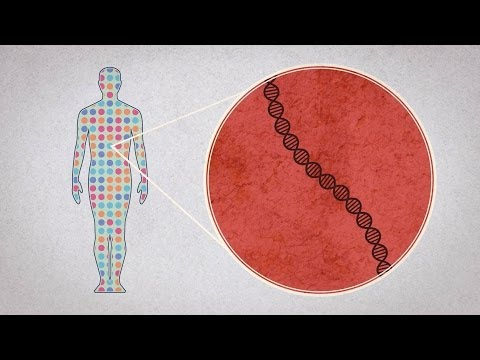

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("MvuYATh7Y74",width=640,height=360)

A string of DNA is very long. No one has developed the technology to measure a single DNA (or RNA) molecule sequence in one pass. We can sequence smaller pieces ("sequences") of DNA, however.  The trick then becomes to figure out a way to use small-sequence technology to measure the entire big sequence (i.e., the entire DNA molecule).

A solution that seems to work quite well is to take DNA (actually, a lot of DNA molecules) and cut it up into short pieces that we can read.  We can read these small pieces easily, but then we need to figure out how to put them together to get the original long DNA sequence.  This is challenging because there are many little pieces that overlap with each other, and reassembling this into the correct sequence may take quite a bit of effort.  This type of assembly is often called "shotgun sequencing."

One way to speed up "shotgun sequencing" is to map the sequences against a known large reference genome, such as the human genome.  The Burrows-Wheeler Aligner is a software package designed to do this type of alignment.  

# Part 1: Download Example

All of the files referenced in the original PI's email are included in the course Git repository in the directory called ```HW3_Example```.  

&#9989; <font color=red>**DO THIS:**</font> Do a ```git pull``` in your class directory on the HPC and review the provided files. Since you will be modifying the files, you may want to make a copy of the directory to keep around as a reference (Or branch your git repo). 

Time how long it takes to download the data as described in the PI's email.  Although the downloads can take a while this is a onetime cost which will not significantly impact the assemblies workflow. Make modifications to ```getGiabData.sh``` to time and download all of the data.  

Make sure you note how long the each download takes.

# Part 2: Time BWA Index

&#9989; <font color=red>**DO THIS:**</font> Time and execute the the BWA index program as described in ```runBwaIndex_slurm_giab.sb```.  Modify the program to fix any bugs and to streamline the workflow. 

**Note:** The PI's instructions are incomplete (this is common). You will need to debug their workflow to get everything to work.  Some things to keep in mind:

- Their group may have changed their ```.bashrc``` file to automatically load a different set of modules than the defaults. Read the ouput errors from the job and modify the ```runBwaIndex_slurm_giab.sb``` script to load the correct modules using local path references. Try to write the ```module``` commands in such a way so that the script should work for anyone on the HPCC even if they have different default modules.
- They also may have hard-coded the file Paths. Modify the script in a way so that all the paths reference the current working directory.  Make the code portable so that changing the name of the parent folder will not impact the execution of the scripts. 
- Remember to debug the script by running it on one of the Development nodes.  This can be much faster than submitting a bunch of scripts and waiting for them to run. You can also open a second terminal on the same development node and run ```top``` to see how much CPU and memory is being used.
   
Make sure you keep track of how long the indexing takes to run.

**INSTRUCTORS HINT:** The memory and time requests in the provided index script are way too small and will cause the scheduler to kick out the jobs when the go over their resource limits.  It is taking me quite a few test jobs to find a memory and time that will work without starting over. I recommend setting these things to very high numbers (Ex 40gb and 24 hours) and then using the ```sacct --format="CPUTime,MaxRSS"``` command or the ```js -j $SLURM_JOB_ID -F``` command at the end of your submission script to provide the actual resource requirements.  You can then change the requested resources in your job script to better match what is actually being used. 

I have also reached out to the PI to see if we can get a shorter example to make debugging a little faster. 

# Part 3: Benchmark BWA Serial Assembly

&#9989; <font color=red>**DO THIS:**</font> Time and execute the the BWA assembly program as described in ```runBwaAln_slurm_giab_noRg.sb```.  Modify the program to fix any bugs and to streamline the workflow. See Notes in **Part 2**.  Run this assembly more than once to establish a baseline time for this step. You will need this baseline time for comparison in **Part 4.** (I recommend running each test in a different directory to avoid file conflicts).  You can also run these tests as you are working on the other parts of this homework (work in parallel!). 

Make sure you keep track of the average time it takes to run the indexing.

 # Part 4: Parallel Scaling
&#9989; <font color=red>**DO THIS:**</font> Debug the SLURM assembly submission script and make it run on multiple CPUs.  Conduct benchmarks with different numbers of CPUs and record both the Queue Time (time the job spent in the queue waiting for resources) and the run time (time the job took to run).  Graph your results and identify the settings you think are optimal for this workflow.

**HINTS:** Read though the PIs email and see if you can identify any assumptions they may be making.  For example, what type of parallel library does BWA use (Shared memory or shared network)?  Are the resources requested consistent with these assumptions.  Experiment with short jobs or on a development node's command line. Read the BWA documentation and take advantage of Google.


# Part 5: Self Contained Example

Now that we figured out all of the details, this workflow would make a great example to include in the ```getexample``` program on the HPCC. 

&#9989; <font color=red>**DO THIS:**</font> Create a new "Answer" directory similar to a ```getexample``` folder with all of the files and steps organize into a single workflow.  Write a README file and include it in your folder.  Make the README file executable so that by typing ```./README``` will download the required files and run the example in the most optimal configuration based on your timing studies. 

**CAUTION:** We do not want to make the Answer folder too big.  Include all of the necessary scripts as part of the workflow. **DO NOT** include the data files in your Answer directory, they are WAY too big.  Also make sure you do not include any extra files generated by the workflow (ex. .out, .pac, .amb, .ann and .sam files), you only want files that are needed to run the example.

# Part 6: Final Report
&#9989; <font color=red>**DO THIS:**</font> Write a short (approx. 1-page) report for this homework and put it in your ```getexample``` answer directory.  Include as much of the assignment as you were able to get done and explain where you got stuck (if you did).  Make sure you include the timing results and the corresponding graphs for the scaling study from above.  Write this report as an email response to the PI, describe the changes you made to their files and explain why you made each of the changes. Include all the instructions needed to run your example.  Also include any ideas you have for future improvements of the workflow but did not have any time to research, implement and/or test.

# Part 7: Final Testing

&#9989; <font color=red>**DO THIS:**</font> When you are done, zip up your entire "answer" directory (without the large data files) into a tgz file using the ```tar``` command with compression.  Go to a different directory on the HPC and "untar" the entire folder.  Run the ```./README``` command one last time and make sure the entire example runs from beginning to end.  

----

### Turning in your homework

Now, you need to submit this assignment by uploading your tgz file to the course Desire2Learn web page. Make sure you include your report and source code so the instructor may reproduce your results. 

&#169; Copyright 2019,  Michigan State University Board of Trustees